In [130]:
#import
import gensim
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import datetime
from scipy import stats 
from datetime import datetime, timedelta
import time
import sklearn as sk
import nltk
import sqlite3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
import re
import random
import sys
from sklearn.cluster import AffinityPropagation
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
#import data and review content
conn = sqlite3.connect('JobDBa.db')
cur = conn.cursor()
#21000 job descriptions at this time
cur.execute('SELECT * FROM [Jobs Indeed]')
data = cur.fetchall()
dfa = pd.DataFrame(data=data, columns=['Job Title', 'Company','Location','Description'])
print(dfa.describe())
dfa.isna().sum()

             Job Title          Company     Location  \
count            21187            21187        21187   
unique           14419             7719         1250   
top     Data Scientist  JP Morgan Chase  Toronto, ON   
freq               470              403          968   

                                              Description  
count                                               21187  
unique                                              21187  
top     Job Description:\nAt EXP, we know that great e...  
freq                                                    1  


Job Title      0
Company        0
Location       0
Description    0
dtype: int64

**From initial observations on the dataset, there have been no issues with the scraper getting all intact data from indeed. There are no missing values for any of the scraped information categories. The current dataset has 21,000 unique job descriptions to perform clustering on.** 

In [125]:
dfs = dfa.sample(frac=.15)
add_stop=['lab','laboratory','company','inc','technology','computer','institute','public','\r','connect','people','fb','g','ge',
          'accomadate','sexuality','sex','orientation','orient','gender','race','ethnicity','ethnic','equal','opportunity','minor',
          'disable','veteran','female','male','employer','employee','network','require','affirm','jp','jpmorgan','chase','usa','america','canada',
          'career','job','compani', 'work','location','origin','religion','ident','sexual','color','identity','nation','national',
         'disability','protect','protected','background','screening','screen','drug','diversity','diverse','employment',
         'employ','affirimative','action','applicant','discrimination','discriminate','apply','application', 'resume','agency','agent',
         '\r \r', 'proud','inclusive','inclusion','recruit','recruitment','recruiter','hire','submit','agree','agreement',
         'marital', 'status', 'marriage', 'help','require','perform','duty','duti','provide','accomod', 'authorization','author',
         'type','time','salary', '00','000 00', '000', 'citizenship','citizen','large','identify','crime','criminal', 
         'ancestry', "you're","you'r","we're","we'r"]
stemmer = SnowballStemmer('english')
punc = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'",'-','>','<','/','^', ''] #remove punctuation for initial analysis
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stopw = nltk.corpus.stopwords.words('english')
stop_words = stop_words.union(stopw)
stop_words = stop_words.union(add_stop)
sw = [n for n in stop_words]
for i in range(1,20):
    itn = str(i)
    try:
        sw == sw.remove(itn)
    except:
        pass
print(len(sw))
stop_words = frozenset(sw)

stem_stop = [stemmer.stem(word) for word in stop_words]
def rst(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
#     tokde = [line.decode('utf-8').strip() for line in tok]
    stem = [stemmer.stem(word) for word in tok]
    h = [n for n in stem if not n in stem_stop]
    return h
def rstu(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
    tokde = [line.decode('utf-8').strip() for line in tok]
    stem = [stemmer.stem(word) for word in tok]
    h = [n for n in stem if not n in stem_stop]
    return h
    
#     return stem
test= "The big world isn't go\ing to go a\r\nw\iay\r. \r \rCompanies will not yield"

company = dfa.Company.unique()
pcom = []
for item in company:
    spl = word_tokenize(item)
    for itm in spl:
        pcom.append(itm.lower())
pnd = list(set(pcom))
stop_words = stop_words.union(pnd)
# print(stop_words)
# stem_stop = [stemmer.stem(word) for word in stop_words]
def rstnoc(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
#     tokde = [line.decode('utf-8').strip() for line in tok]
    h = [n for n in tok if not n in stop_words]
    stem = [stemmer.stem(word) for word in h]
    return stem
#out :[u'big', u'world', u'ing', u'w', u'iay', u'yield']

516


In [120]:
from nltk.tokenize import sent_tokenize
from operator import itemgetter
tv = TfidfVectorizer(tokenizer=sent_tokenize)
tmat =tv.fit_transform(dfs['Description'])
tf = tv.get_feature_names()
tmata = tmat.toarray()
tmatat = tmata.transpose()
tl = []
for item,name in zip(tmatat, tf):
    tl.append([name, item.mean()])

In [121]:
from nltk.tokenize import sent_tokenize
from operator import itemgetter
tv = CountVectorizer(tokenizer=sent_tokenize)
tmat =tv.fit_transform(dfs['Description'])
tf = tv.get_feature_names()
tmata = tmat.toarray()
tmatat = tmata.transpose()
tl = []
for item,name in zip(tmatat, tf):
    tl.append([name, item.mean()])

In [126]:
len(dfs['Description'])

count= 0
newl = []
for item in tl:
    if item[1] >= ((1/3178)*1.1):
        count+=1
        newl.append(item)
nono = []
for item in newl:
    reg = re.search('[ ]', item[0])
    if reg is None:
        nono.append(item)
nnl = [n for n in newl if n not in nono]

def scent_token(text):
    sent = sent_tokenize(text)
    nxt = [u for u in sent if u not in nnl]
    string = ''.join(nxt)
    nre = re.sub(r"(\n)", r" ", string)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
    h = [n for n in tok if not n in stop_words]
    stem = [stemmer.stem(word) for word in h]
    return stem


#HCSC is committed to diversity in the workplace and to providing equal opportunity and affirmative action to employees and applicants. We are an Equal Opportunity Employment / Affirmative Action employer dedicated to workforce diversity and a drug-free and smoke-free workplace. Drug screening and background investigation are required, as allowed by law. All qualified applicants will receive consideration for employment without regard to race, color, religion, sex, sexual orientation, gender identity, national origin, disability, or protected veteran status.

In [127]:
tfd = TfidfVectorizer(max_df=0.8, min_df=.020, stop_words=stop_words, tokenizer=scent_token)#limit max appearance of word 
tvt = tfd.fit_transform(dfs['Description'])
krt = KMeans(n_clusters=9)
krt.fit(tvt)
kmt = krt
regt = kmt.labels_.tolist()
dfrt = pd.DataFrame()
dfrt['Job Title'] = dfs['Job Title'].copy()
dfrt['Company'] = dfs['Company'].copy()
dfrt['Location'] = dfs['Location'].copy()
dfrt['Description'] = dfs['Description'].copy()
dfrt['Cluster'] = regt
dfrt['Cluster'].value_counts()
order_centroidt = kmt.cluster_centers_.argsort()[:, ::-1] 
termt = tfd.get_feature_names()
for i in range(9):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidt[i, :50]: #replace 6 with n words per cluster
        print(' %s ' % termt[ind])
    print('\n') #add whitespace

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1stdib', '20', '30', '3deolidar', '800courier', '9', '911', 'a9', 'academia', 'ade', 'alarm', 'alcatel', 'algonquin', 'ar', 'arcadia', 'aric', 'autotrad', 'avenuecod', 'avi', 'bake', 'benz', 'bian', 'bristol', 'broker', 'buc', 'bug', 'c3', 'callstat', 'cana', 'cetra', 'charityusa', 'chem', 'chiat', 'cimpress', 'cirruslab', 'ck', 'cmi', 'collag', 'compa', 'compress', 'connor', 'copernicus', 'cor', 'crush', 'ctrl', 'cypress', 'dana', 'depth', 'digitalshopp', 'discours', 'dkmanufactur', 'driverbas', 'dyck', 'edmund', 'edu', 'ee', 'encor', 'everestlab', 'fairbank', 'farber', 'finn', 'fleishman', 'form', 'forman', 'frame', 'freelanc', 'fun', 'futurewei', 'ga', 'gg', 'gi', 'gmo', 'gso', 'h2o', 'h2r', 'har', 'hare', 'herm', 'hillard', 'hiretu', 'hiv', 'hra', 'htfc', 'ice', 'ii', 'iii', 'imanag',

Cluster 0 words: 
 model 
 statist 
 algorithm 
 scientist 
 python 
 techniqu 
 problem 
 develop 
 quantit 
 skill 
 deep 
 build 
 mathemat 
 ml 
 understand 
 includ 
 strong 
 program 
 relat 
 complex 
 requir 
 method 
 qualif 
 creat 
 make 
 improv 
 nlp 
 degre 
 implement 
 set 
 respons 
 collabor 
 look 
 role 
 process 
 passion 
 deploy 
 deliv 
 leverag 
 posit 
 candid 
 languag 
 need 
 dataset 
 solv 
 analyz 
 approach 
 tensorflow 
 present 
 bring 


Cluster 1 words: 
 process 
 requir 
 ensur 
 skill 
 function 
 develop 
 implement 
 includ 
 respons 
 need 
 strong 
 execut 
 issu 
 relat 
 train 
 provid 
 analyst 
 understand 
 excel 
 lead 
 maintain 
 improv 
 activ 
 role 
 demonstr 
 posit 
 deliv 
 collabor 
 oper 
 degre 
 specif 
 qualif 
 problem 
 valid 
 audit 
 effect 
 individu 
 review 
 creat 
 – 
 procedur 
 chang 
 leadership 
 success 
 make 
 recommend 
 initi 
 coordin 
 analyz 
 facilit 


Cluster 2 words: 
 make 
 develop 
 build 
 look 


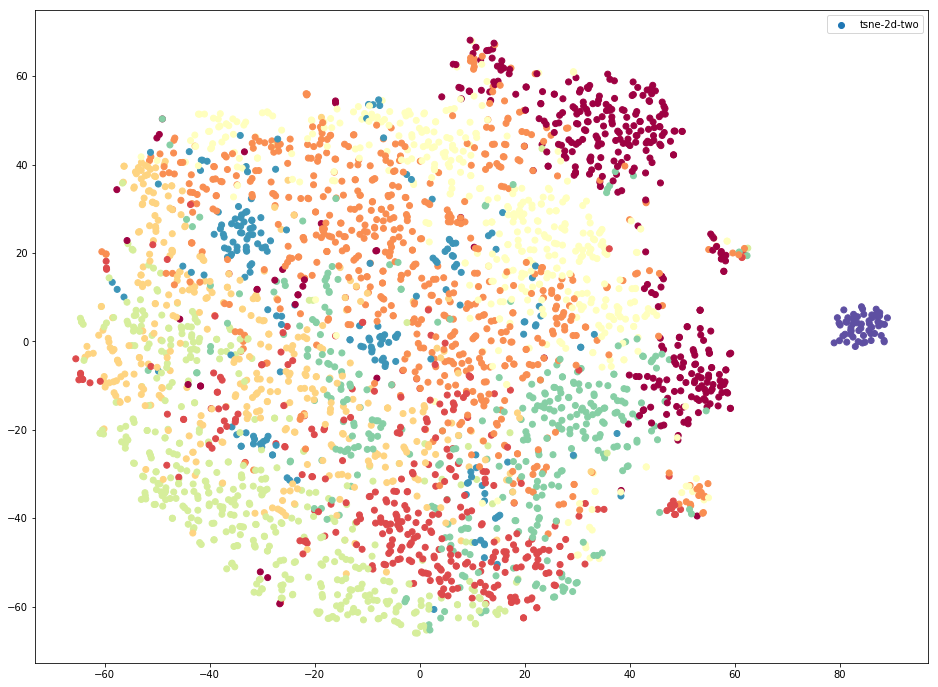

In [151]:
dist = 1 - cosine_similarity(tvt)
# pca = PCA(n_components=50)
# pcad = pca.fit_transform(dist)
tpc = TSNE(n_components=2).fit_transform(dist)
import seaborn as sns
dfrt['tsne-2d-one'] = tpc[:,0]
dfrt['tsne-2d-two'] = tpc[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

In [118]:
dfrt['Cluster'].value_counts()

7    722
2    508
8    434
5    363
6    344
4    233
3    219
1    181
0    174
Name: Cluster, dtype: int64

In [139]:
import gensim
from gensim.models import word2vec
tfu = CountVectorizer(tokenizer=wordpunct_tokenize)
tfu.fit_transform(dfs['Description'])
fn = tfu.get_feature_names()
print(len(fn))

32714


In [131]:
wpt = nltk.WordPunctTokenizer()
token_corpus = [wpt.tokenize(document) for document in dfs.Description.values]

In [140]:
feature_size = 50    # Word vector dimensionality  
window_context = 12          # Context window size                                                                                    
min_word_count = 2   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words
w2v_model = word2vec.Word2Vec(token_corpus, size=feature_size,
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=40)


In [141]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=token_corpus, model=w2v_model,
                                             num_features=feature_size)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [146]:
ap = AffinityPropagation()
ap.fit(w2v_feature_array)
kmw = KMeans(n_clusters=9)
kmw.fit(w2v_feature_array)
dfrt['KMClusterW2V'] = kmw.labels_
cluster_labels = ap.labels_
dfrt['AfClusterW2V'] = cluster_labels


In [147]:
apt = AffinityPropagation()
apt.fit(tvt)
dfrt['AFCTF'] = apt.labels_

In [149]:
dfrt.head(50)

,Job Title,Company,Location,Description,Cluster,AfClusterW2V,KMClusterW2V,AFCTF
11560,Executive Director - Software Engineering,JP Morgan Chase,"Lewisville, TX 75067",J.P. Morgan Chase & Co. (NYSE: JPM) is a leadi...,8,108,1,33
19413,Geographic Information Systems (GIS) Analyst I...,Texas Department of Transportation,"Austin, TX 78704",TxDOT's Aviation Division is looking for a Geo...,5,30,8,33
13006,Data Engineer,Slalom Consulting,"Silicon Valley, CA",Slalom is a purpose-driven consulting firm tha...,4,73,4,33
5698,"Sr. Functional Engineer, Data and Analytics",Align Technology,"San Jose, CA 95131",Join a team that is changing millions of lives...,1,97,1,33
1962,Software QA Engineer,MindBeacon,"Toronto, ON","About BEACONLaunched October 2017, BEACON is a...",7,2,3,33
8218,"Sr Manager, Business Intelligence",T-Mobile,"Bellevue, WA","Job Description:\n\nSr Manager, Business Intel...",6,41,0,33
439,Software Development Engineer Co-op - Fall 201...,"AMZN CAN Fulfillment Svcs, ULC","Vancouver, BC",Currently enrolled in a Bachelor’s or Master’s...,2,109,7,33
2161,Senior Software Engineer (Toronto),Zero,"Toronto, ON",OVERVIEW\n\nAs an early member of our engineer...,4,26,4,33
9791,Machine Learning Research Engineer,Osaro,"San Francisco, CA",We are searching for a full-time machine learn...,0,77,4,33
16945,Business Analyst Information Technology II,NETpro System Inc.,"Torrance, CA",I can only place a candidate on my W2.NO C2CNe...,1,51,5,33


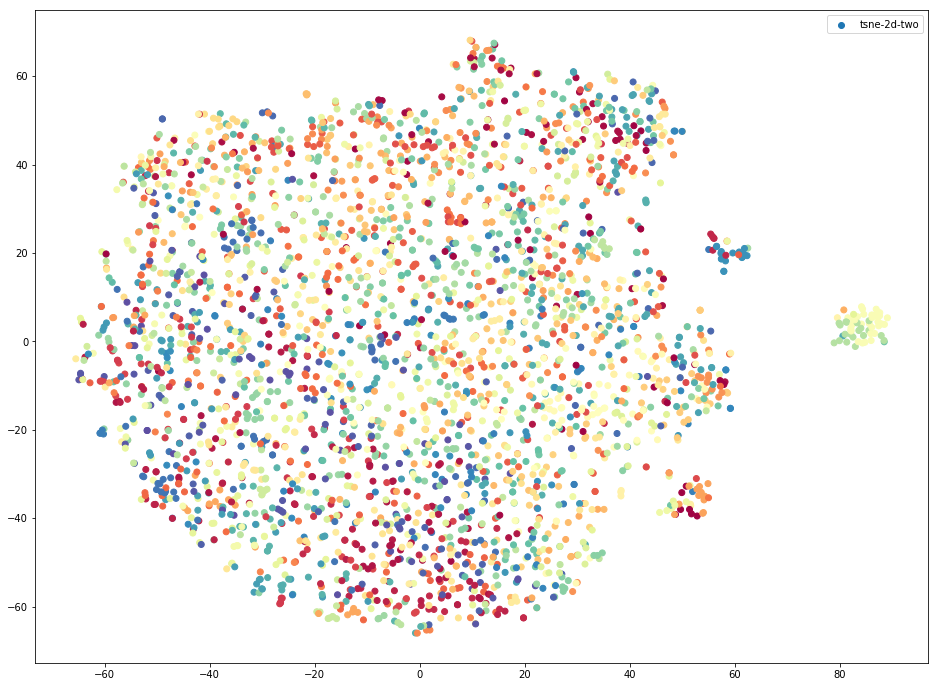

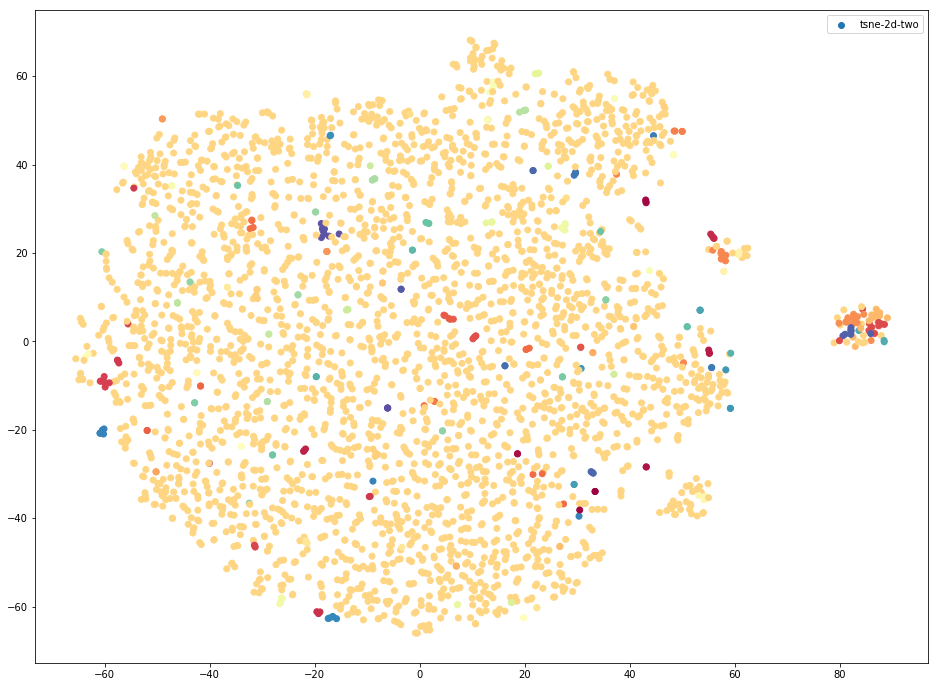

In [152]:
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['AfClusterW2V'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['AFCTF'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

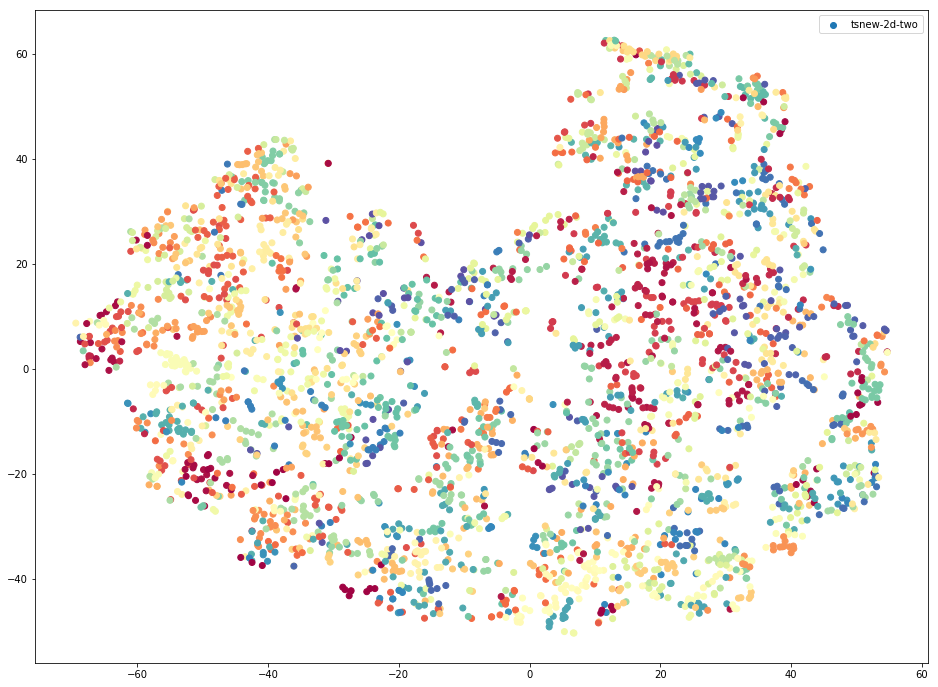

In [154]:
distw = 1 - cosine_similarity(w2v_feature_array)
tpcw = TSNE(n_components=2).fit_transform(distw)
import seaborn as sns
dfrt['tsnew-2d-one'] = tpcw[:,0]
dfrt['tsnew-2d-two'] = tpcw[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsnew-2d-one'],dfrt['tsnew-2d-two'], c=dfrt['AfClusterW2V'], cmap='Spectral')
plt.legend()

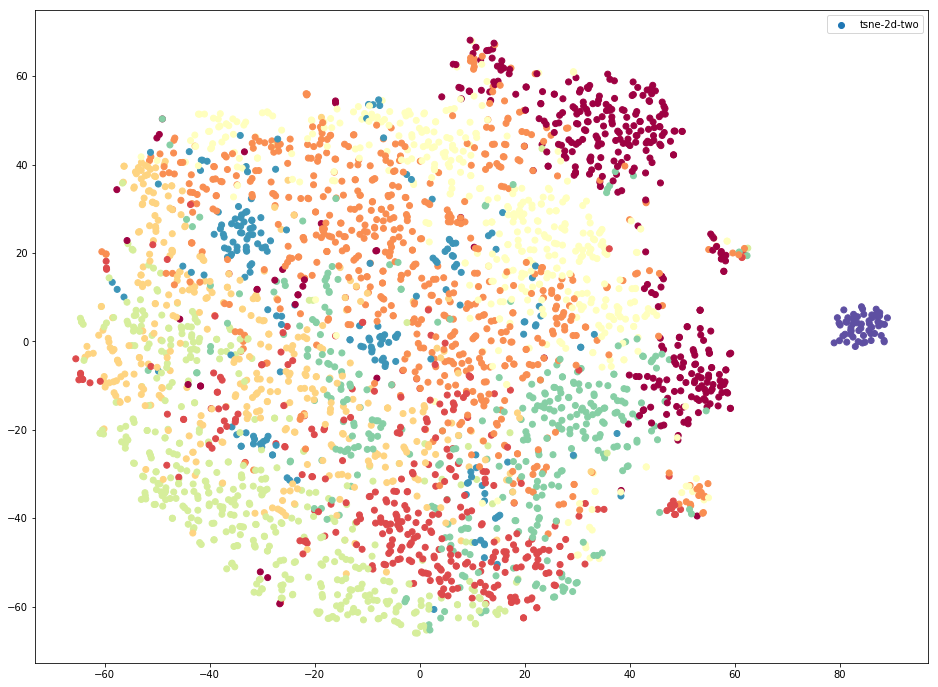

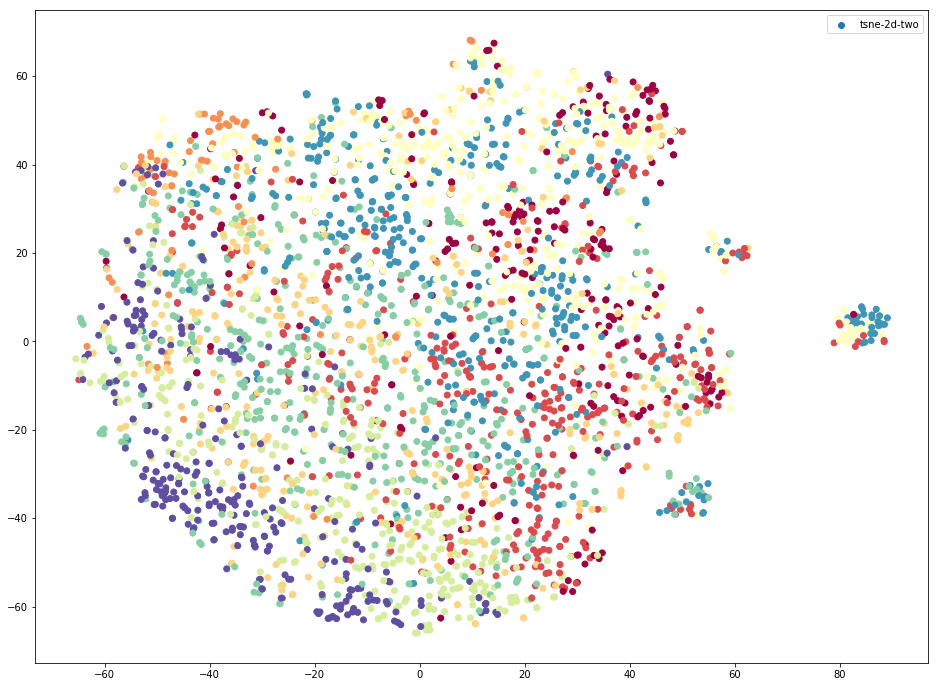

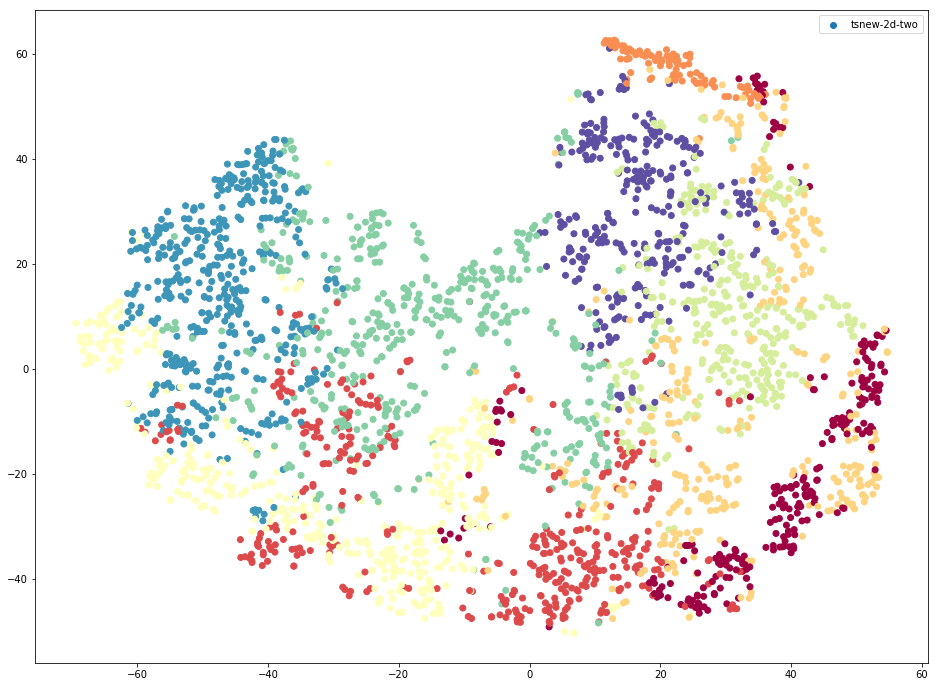

In [155]:
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['KMClusterW2V'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsnew-2d-one'],dfrt['tsnew-2d-two'], c=dfrt['KMClusterW2V'], cmap='Spectral')
plt.legend()